In [1]:
!pip install yfinance pandas numpy matplotlib seaborn


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing and visualization of Seasonality

In [3]:
# Normalize cycles to a common timeline
def normalize_cycles(all_data, halving_dates):
    cycle_data = {}
    for i in range(1, len(halving_dates)):
        start_date = halving_dates[i]
        end_date = halving_dates[i + 1] if i + 1 in halving_dates else all_data['Date'].max()
        mask = (all_data['Date'] >= start_date) & (all_data['Date'] < end_date)
        cycle_df = all_data.loc[mask].copy()
        cycle_df['Day_in_Cycle'] = (cycle_df['Date'] - start_date).dt.days + 1
        cycle_data[i] = cycle_df
    return cycle_data

# Apply the function
cycle_data = normalize_cycles(all_data, halving_dates)
cycle_data

NameError: name 'all_data' is not defined

In [ ]:
# Function to calculate risk-adjusted metrics
def calculate_risk_metrics(returns):
    mean_return = returns.mean()
    volatility = returns.std()
    sharpe_ratio = mean_return / volatility if volatility != 0 else np.nan
    sortino_ratio = mean_return / returns[returns < 0].std() if returns[returns < 0].std() != 0 else np.nan
    cvar = returns[returns <= returns.quantile(0.05)].mean()
    return {
        'Mean Return': mean_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'CVaR': cvar
    }

# Apply to yearly data
for cycle, df in cycle_data.items():
    yearly_metrics = df.groupby('Year')['Return'].apply(calculate_risk_metrics)
    # Convert to DataFrame
    yearly_metrics_df = pd.DataFrame(list(yearly_metrics.values), index=yearly_metrics.index)
    print(f"\nCycle {cycle} Yearly Risk Metrics:")
    print(yearly_metrics_df)


In [ ]:
from scipy.stats import skew, kurtosis

def adjusted_kelly_fraction(returns):
    """
    Adjusted Kelly Fraction accounting for skewness and kurtosis.
    """
    mean_return = returns.mean()
    variance = returns.var()
    skewness = skew(returns)
    kurt = kurtosis(returns)
    # Adjusted for higher moments
    kelly_fraction = mean_return / variance - (skewness * mean_return**2) / (2 * variance**2) + \
                     ((kurt - 3) * mean_return**3) / (3 * variance**3)
    return kelly_fraction

# Apply to daily returns
for cycle, df in cycle_data.items():
    df['Adjusted_Kelly'] = df['Return'].rolling(window=30).apply(adjusted_kelly_fraction)

In [ ]:
def simulate_strategy(returns, kelly_fraction, initial_capital=1.0, n_simulations=1000):
    final_capitals = []
    for _ in range(n_simulations):
        capital = initial_capital
        for r in returns:
            bet_size = kelly_fraction * capital
            gain = bet_size * r
            capital += gain
            if capital <= 0:
                break  # Ruin
        final_capitals.append(capital)
    ruin_probability = sum(1 for c in final_capitals if c <= 0) / n_simulations
    expected_final_capital = np.mean(final_capitals)
    return ruin_probability, expected_final_capital

# Example usage
daily_returns = all_data['Return'].dropna().values
kelly_frac = 0.1  # Use a conservative fraction
ruin_prob, exp_final_cap = simulate_strategy(daily_returns, kelly_frac)
print(f"Probability of Ruin: {ruin_prob*100:.2f}%")
print(f"Expected Final Capital: {exp_final_cap:.2f}")


## 6. Data Visualization

In [ ]:
# Highlight Halving Weeks in the dataset
all_data['Halving'] = False
for halving_date in halving_dates.values():
    halving_week = halving_date.isocalendar()[1]
    halving_year = halving_date.year
    # Mark the data corresponding to the halving week
    all_data.loc[
        (all_data['Year'] == halving_year) &
        (all_data['Week_Number'] == halving_week), 'Halving'
    ] = True
# Custom colormap for heatmap
colors = [
    '#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7',
    '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061'
]
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
for ticker in tickers:
    ticker_data = all_data[all_data['Ticker'] == ticker]
    pivot_table = ticker_data.pivot_table(
        index='Week_Number', columns='Year', values='Return', aggfunc='mean'
    )

    plt.figure(figsize=(20, 12))
    sns.heatmap(
        pivot_table * 100,
        cmap=cmap, center=0, annot=False, fmt=".1f",
        cbar_kws={'label': 'Average Weekly Return (%)'}
    )

    # Highlight Halving Weeks
    for halving_date in halving_dates.values():
        halving_week = halving_date.isocalendar()[1]
        plt.axhline(y=halving_week - 0.5, color='yellow', linewidth=2)

    plt.title(f'Weekly Seasonality Heatmap for {ticker}', fontsize=20)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Week Number', fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
for ticker in tickers:
    ticker_data = all_data[all_data['Ticker'] == ticker]
    plt.figure(figsize=(20, 10))
    plt.semilogy(ticker_data['Date'], ticker_data['Adj Close'], label='Adjusted Close Price')
    for idx, halving_date in halving_dates.items():
        label = f'Halving {idx}' if idx == 1 else None
        plt.axvline(x=halving_date, color='red', linestyle='--', label=label)
    plt.title(f'{ticker} Price Over Time with Halving Dates', fontsize=20)
    plt.xlabel('Date')
    plt.ylabel('Price (USD) - Log Scale')
    if idx == 1:
        plt.legend(fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


# Attempt 2

In [4]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

# Financial data libraries
import yfinance as yf

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific computing libraries
from scipy.stats import skew, kurtosis

# Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set plotting style
plt.style.use('seaborn-darkgrid')


/tmp/ipykernel_157066/3453984854.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [5]:
# Define tickers
tickers = ['BTC-USD', 'ETH-USD']

# Define the start and end dates
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Fetch data
data = yf.download(tickers, start=start_date, end=end_date)
print("Data fetched successfully.")


[*********************100%***********************]  2 of 2 completed

Data fetched successfully.


In [6]:
class TechnicalSeasonalityAnalyzer:
    def __init__(self, data, tickers):
        self.data = data
        self.tickers = tickers

    def calculate_technical_indicators(self):
        for ticker in self.tickers:
            close_price = self.data['Close'][ticker]
            high_price = self.data['High'][ticker]
            low_price = self.data['Low'][ticker]
            volume = self.data['Volume'][ticker]
            
            # 20-Day Bollinger Bands
            self.data[f'{ticker}_20D_MA'] = close_price.rolling(window=20).mean()
            self.data[f'{ticker}_20D_STD'] = close_price.rolling(window=20).std()
            self.data[f'{ticker}_20D_Upper'] = self.data[f'{ticker}_20D_MA'] + 2 * self.data[f'{ticker}_20D_STD']
            self.data[f'{ticker}_20D_Lower'] = self.data[f'{ticker}_20D_MA'] - 2 * self.data[f'{ticker}_20D_STD']
            
            # 52-Week Bollinger Bands
            self.data[f'{ticker}_52W_MA'] = close_price.rolling(window=364).mean()
            self.data[f'{ticker}_52W_STD'] = close_price.rolling(window=364).std()
            self.data[f'{ticker}_52W_Upper'] = self.data[f'{ticker}_52W_MA'] + 2 * self.data[f'{ticker}_52W_STD']
            self.data[f'{ticker}_52W_Lower'] = self.data[f'{ticker}_52W_MA'] - 2 * self.data[f'{ticker}_52W_STD']
            
            # Relative Strength Index (RSI)
            delta = close_price.diff()
            gain = delta.clip(lower=0).rolling(window=14).mean()
            loss = -delta.clip(upper=0).rolling(window=14).mean()
            rs = gain / loss
            self.data[f'{ticker}_RSI'] = 100 - (100 / (1 + rs))
            
            # MACD
            exp1 = close_price.ewm(span=12, adjust=False).mean()
            exp2 = close_price.ewm(span=26, adjust=False).mean()
            self.data[f'{ticker}_MACD'] = exp1 - exp2
            self.data[f'{ticker}_MACD_Signal'] = self.data[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
            
            # Stochastic Oscillator
            low_14 = low_price.rolling(window=14).min()
            high_14 = high_price.rolling(window=14).max()
            self.data[f'{ticker}_K'] = 100 * ((close_price - low_14) / (high_14 - low_14))
            self.data[f'{ticker}_D'] = self.data[f'{ticker}_K'].rolling(window=3).mean()
            
            # Rate of Change (ROC)
            self.data[f'{ticker}_ROC'] = ((close_price - close_price.shift(10)) / close_price.shift(10)) * 100

    def analyze_overbought_oversold(self):
        results = {}
        for ticker in self.tickers:
            overbought = (
                (self.data[f'{ticker}_RSI'] > 70) |
                (self.data['Close'][ticker] > self.data[f'{ticker}_20D_Upper']) |
                (self.data['Close'][ticker] > self.data[f'{ticker}_52W_Upper']) |
                (self.data[f'{ticker}_K'] > 80) |
                (self.data[f'{ticker}_D'] > 80) |
                (self.data[f'{ticker}_MACD'] > self.data[f'{ticker}_MACD_Signal']) |
                (self.data[f'{ticker}_ROC'] > 10)
            )
            oversold = (
                (self.data[f'{ticker}_RSI'] < 30) |
                (self.data['Close'][ticker] < self.data[f'{ticker}_20D_Lower']) |
                (self.data['Close'][ticker] < self.data[f'{ticker}_52W_Lower']) |
                (self.data[f'{ticker}_K'] < 20) |
                (self.data[f'{ticker}_D'] < 20) |
                (self.data[f'{ticker}_MACD'] < self.data[f'{ticker}_MACD_Signal']) |
                (self.data[f'{ticker}_ROC'] < -10)
            )
            
            # Resample to monthly and weekly probabilities
            monthly_overbought = overbought.resample('M').mean()
            monthly_oversold = oversold.resample('M').mean()
            weekly_overbought = overbought.resample('W').mean()
            weekly_oversold = oversold.resample('W').mean()
            
            results[ticker] = {
                'monthly_overbought': monthly_overbought,
                'monthly_oversold': monthly_oversold,
                'weekly_overbought': weekly_overbought,
                'weekly_oversold': weekly_oversold
            }
        
        return results

    def plot_overbought_oversold(self, overbought_oversold_results):
        for ticker in self.tickers:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
            
            # Monthly plot
            monthly_data_ob = overbought_oversold_results[ticker]['monthly_overbought'].groupby(overbought_oversold_results[ticker]['monthly_overbought'].index.month).mean()
            monthly_data_ob = monthly_data_ob.reindex(range(1, 13))
            monthly_data_os = overbought_oversold_results[ticker]['monthly_oversold'].groupby(overbought_oversold_results[ticker]['monthly_oversold'].index.month).mean()
            monthly_data_os = monthly_data_os.reindex(range(1, 13))
            
            ax1.bar(monthly_data_ob.index, monthly_data_ob.values, alpha=0.7, color='red', label='Overbought')
            ax1.bar(monthly_data_os.index, monthly_data_os.values, alpha=0.7, color='green', label='Oversold')
            
            ax1.set_title(f'{ticker} Monthly Overbought/Oversold Probability')
            ax1.set_xlabel('Month')
            ax1.set_ylabel('Probability')
            ax1.set_xticks(range(1, 13))
            ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            ax1.legend()
            
            # Weekly plot
            weekly_data_ob = overbought_oversold_results[ticker]['weekly_overbought'].groupby(overbought_oversold_results[ticker]['weekly_overbought'].index.week).mean()
            weekly_data_ob = weekly_data_ob.reindex(range(1, 53))
            weekly_data_os = overbought_oversold_results[ticker]['weekly_oversold'].groupby(overbought_oversold_results[ticker]['weekly_oversold'].index.week).mean()
            weekly_data_os = weekly_data_os.reindex(range(1, 53))
            
            ax2.plot(weekly_data_ob.index, weekly_data_ob.values, color='red', linewidth=2, label='Overbought')
            ax2.plot(weekly_data_os.index, weekly_data_os.values, color='green', linewidth=2, label='Oversold')
            
            ax2.set_title(f'{ticker} Weekly Overbought/Oversold Probability')
            ax2.set_xlabel('Week of the Year')
            ax2.set_ylabel('Probability')
            ax2.set_xticks(range(1, 53, 4))
            ax2.legend()
            
            plt.tight_layout()
            plt.show()


In [7]:
def annotate_halving_events(ax):
    halving_dates = ['2012-11-28', '2016-07-09', '2020-05-11']
    for date in halving_dates:
        ax.axvline(pd.to_datetime(date), color='purple', linestyle='--', linewidth=1, label='Halving' if date == halving_dates[0] else "")
    ax.legend()


In [8]:
class MonthlySeasonalityAnalyzer:
    def __init__(self, ticker='BTC-USD', start='2010-01-01', end=datetime.now().strftime('%Y-%m-%d')):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.data = None
        self.pivot_table = None
        self.summary_table = None

    def fetch_and_process_data(self):
        # Fetch data
        self.data = yf.download(self.ticker, start=self.start, end=self.end, progress=False)['Adj Close']
        print(f"Data for {self.ticker} fetched successfully.")
        
        # Calculate monthly returns
        monthly_data = self.data.resample('M').ffill()
        monthly_returns = monthly_data.pct_change().dropna() * 100  # Percentage
        
        # Organize returns into a pivot table
        monthly_returns = monthly_returns.to_frame(name='Adj Close')
        monthly_returns['Year'] = monthly_returns.index.year
        monthly_returns['Month'] = monthly_returns.index.month_name()
        self.pivot_table = monthly_returns.pivot(index='Year', columns='Month', values='Adj Close')
        self.pivot_table = self.pivot_table.fillna(0)  # Replace NaN with 0
    
    def calculate_metrics(self):
        # Ensure correct month order
        months = ['January', 'February', 'March', 'April', 'May', 'June', 
                  'July', 'August', 'September', 'October', 'November', 'December']
        self.pivot_table = self.pivot_table[months]
        
        # Split data into 4-year cycles
        cycles = []
        years = sorted(self.pivot_table.index)
        for i in range(0, len(years), 4):
            cycle_years = years[i:i+4]
            if len(cycle_years) == 4:
                cycles.append(self.pivot_table.loc[cycle_years])
        
        # Calculate metrics for each cycle
        self.summary_table = {}
        for idx, cycle in enumerate(cycles):
            avg_returns = cycle.mean()
            std_dev = cycle.std()
            pos_perc = (cycle > 0).mean() * 100
            self.summary_table[f'Cycle {idx+1}'] = pd.DataFrame({
                'Avg Returns (%)': avg_returns,
                'StDev (%)': std_dev,
                'Pos %': pos_perc
            })
    
    def visualize_data(self):
        # Plot average returns for each cycle
        for cycle_name, summary in self.summary_table.items():
            plt.figure(figsize=(12, 6))
            plt.bar(summary.index, summary['Avg Returns (%)'])
            plt.title(f'{self.ticker} {cycle_name} - Average Monthly Returns')
            plt.xlabel('Month')
            plt.ylabel('Average Return (%)')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


In [14]:

class WeeklySeasonalityVisualizer:
    def __init__(self, tickers, start_date, end_date, triple_witching_weeks, odds_ratio=2, output_dir='seasonality_data'):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.triple_witching_weeks = triple_witching_weeks
        self.odds_ratio = odds_ratio
        self.output_dir = output_dir
        self.data = None

    def fetch_data(self):
        self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date, group_by='ticker')

    def visualize_weekly_seasonality(self):
        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Return'] = df['Adj Close'].pct_change()
            df['Week_Number'] = df.index.isocalendar().week
            df['Year'] = df.index.year
            df['Ticker'] = ticker

            weekly_data = df.groupby(['Year', 'Week_Number']).agg({
                'Return': 'sum',
                'Volume': 'mean'
            }).reset_index()
            weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

            pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

            sns.heatmap(pivot_data, ax=ax1, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                        cbar_kws={'label': 'Weekly Return'})

            for week in self.triple_witching_weeks:
                ax1.axhline(y=week-0.5, color='yellow', linewidth=2)

            ax1.set_title(f'Seasonality of {ticker} Returns')
            ax1.set_ylabel('Week of Year')
            ax1.set_xlabel('Year')

            avg_weekly_returns = pivot_data.mean(axis=1)
            avg_weekly_returns.plot(ax=ax2, kind='bar', color='skyblue', alpha=0.8)
            ax2.set_title(f'Average Weekly Returns for {ticker}')
            ax2.set_xlabel('Week of Year')
            ax2.set_ylabel('Average Return')
            ax2.axhline(y=0, color='red', linestyle='--')

            for week in self.triple_witching_weeks:
                ax2.bar(week-1, avg_weekly_returns[week], color='yellow', alpha=0.8)

            plt.tight_layout()
            plt.show()

    def export_weekly_seasonality_data(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        for ticker in self.tickers:
            df = self.data[ticker].copy()
            df['Return'] = df['Adj Close'].pct_change()
            df['Week'] = df.index.isocalendar().week
            df['Year'] = df.index.year
            df['Ticker'] = ticker

            weekly_data = df.groupby(['Year', 'Week']).agg({
                'Return': 'sum',
                'Volume': 'mean'
            }).reset_index()

            volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
            positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')

            kelly_ratio = (positive_returns['Positive_Returns'] * self.odds_ratio - 1) / self.odds_ratio
            weekly_data = weekly_data.merge(volatility, on='Week')
            weekly_data = weekly_data.merge(positive_returns, on='Week')
            weekly_data['Kelly_Ratio'] = kelly_ratio

            output_path = os.path.join(self.output_dir, f'{ticker}_seasonality.csv')
            weekly_data.to_csv(output_path, index=False)
            print(f'Saved {ticker} seasonality data to {output_path}')


In [15]:
class CumulativeReturnAnalyzer:
    def __init__(self, ticker, start_date='2010-01-01', end_date=None):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')
    
    def fetch_financial_data(self):
        data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        print(f"Financial data for {self.ticker} fetched successfully.")
        return data

    def calculate_cumulative_return(self, financial_df):
        financial_df['Return'] = financial_df['Adj Close'].pct_change()
        cumulative_returns = (1 + financial_df['Return']).cumprod() - 1
        financial_df['Cumulative Return'] = cumulative_returns
        return financial_df

    def plot_cumulative_return(self, financial_df):
        plt.figure(figsize=(14, 7))
        plt.plot(financial_df.index, financial_df['Cumulative Return'], label='Cumulative Return')
        annotate_halving_events(plt.gca())
        plt.title(f'Cumulative Returns for {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def process(self):
        financial_df = self.fetch_financial_data()
        financial_df = self.calculate_cumulative_return(financial_df)
        self.plot_cumulative_return(financial_df)
        return financial_df['Cumulative Return']


[                       0%                       ]

[*********************100%***********************]  2 of 2 completed


Data fetched successfully.


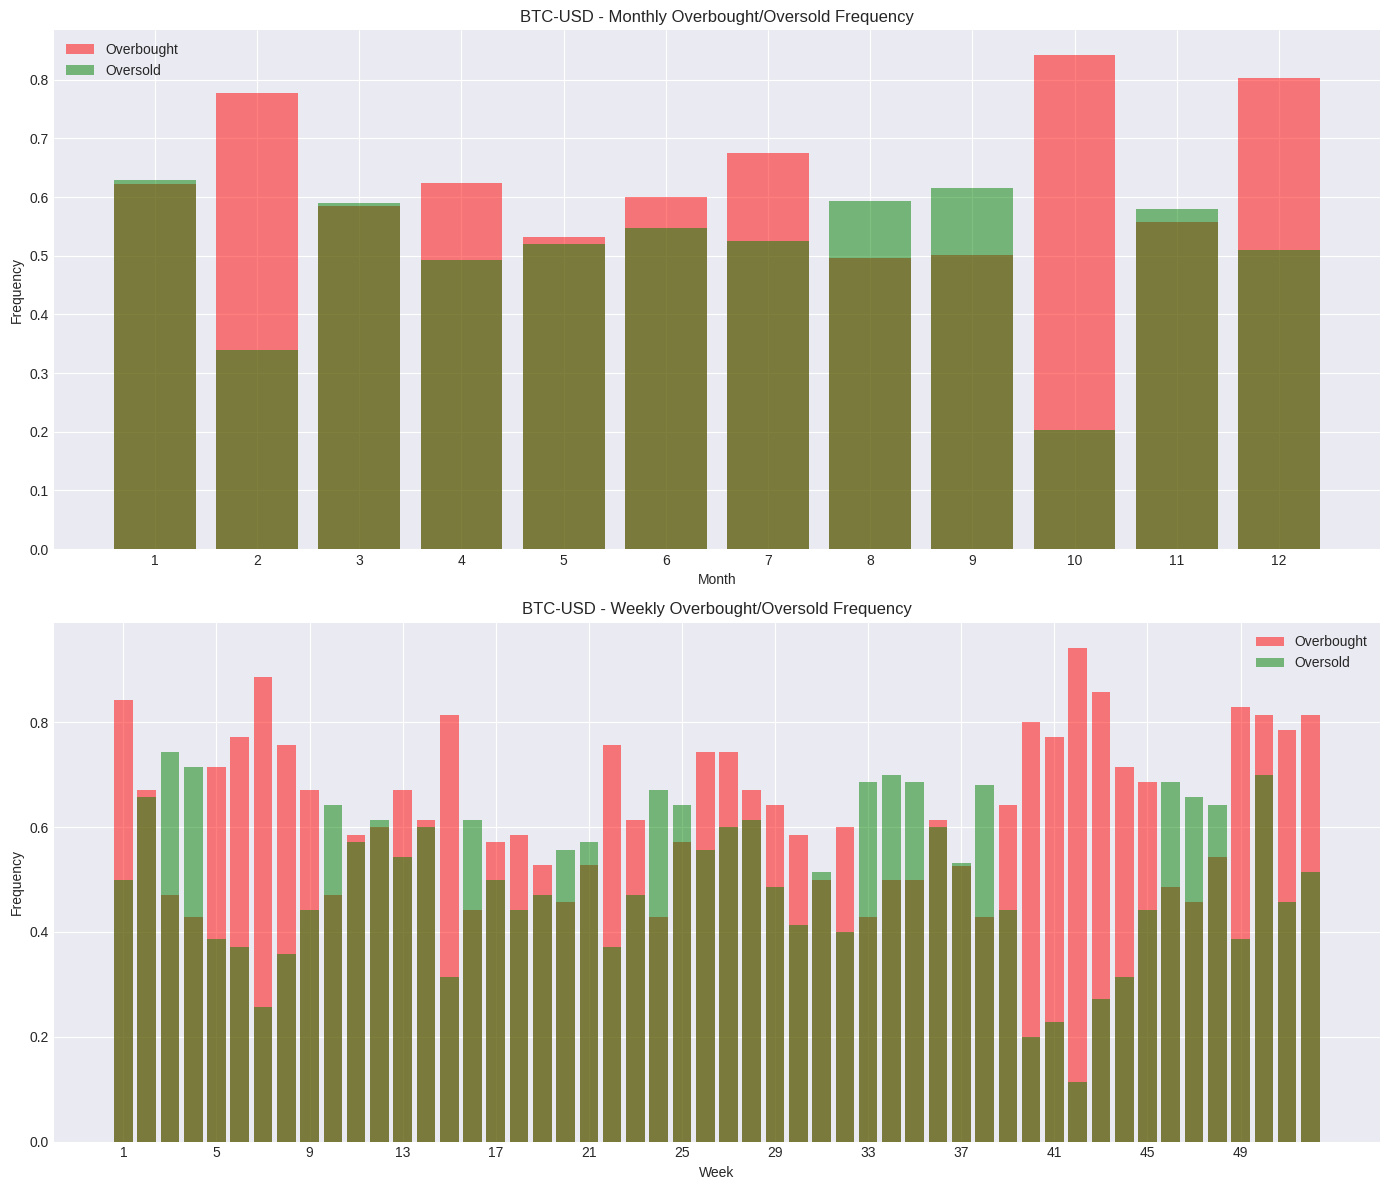

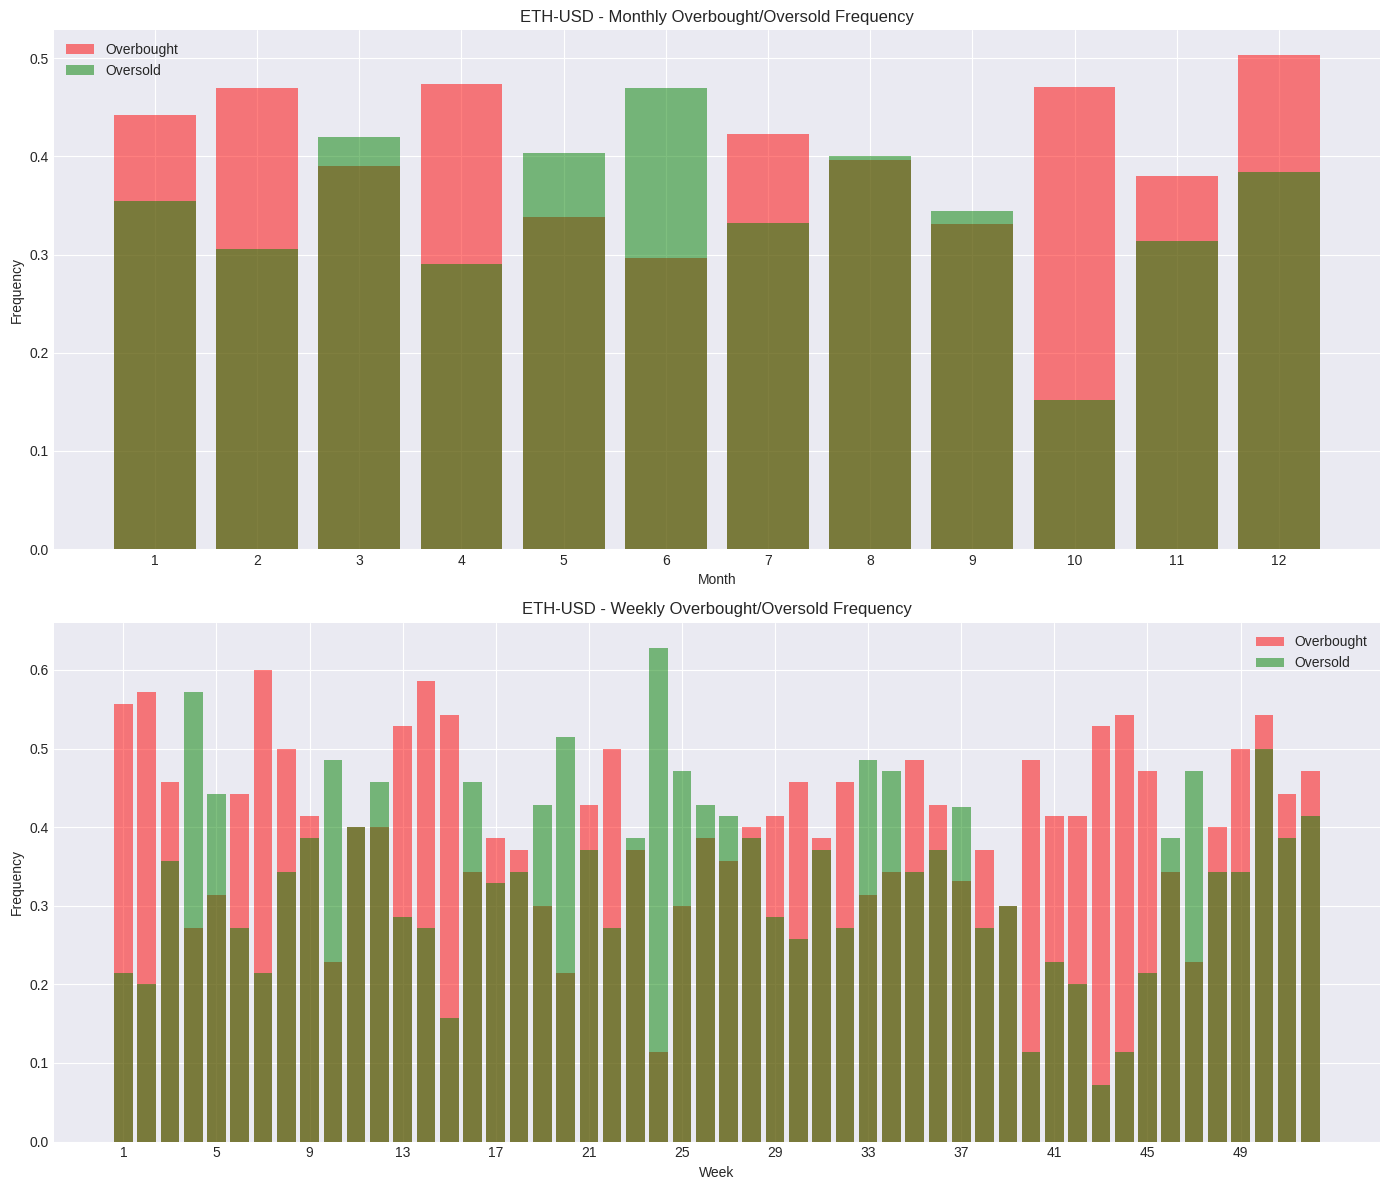

Data for BTC-USD fetched successfully.


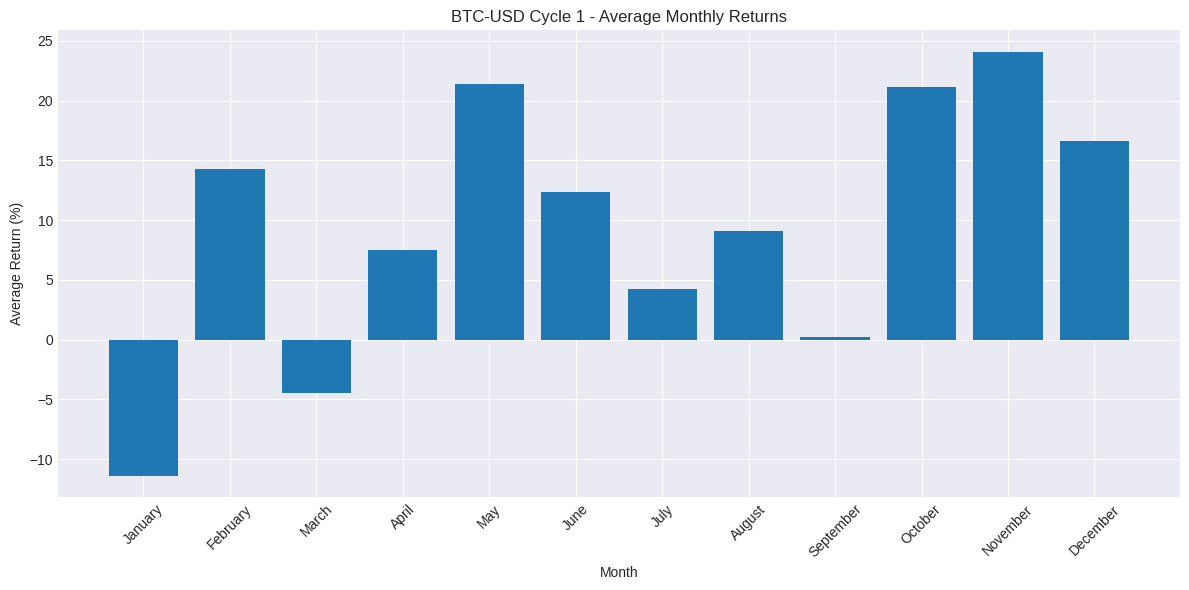

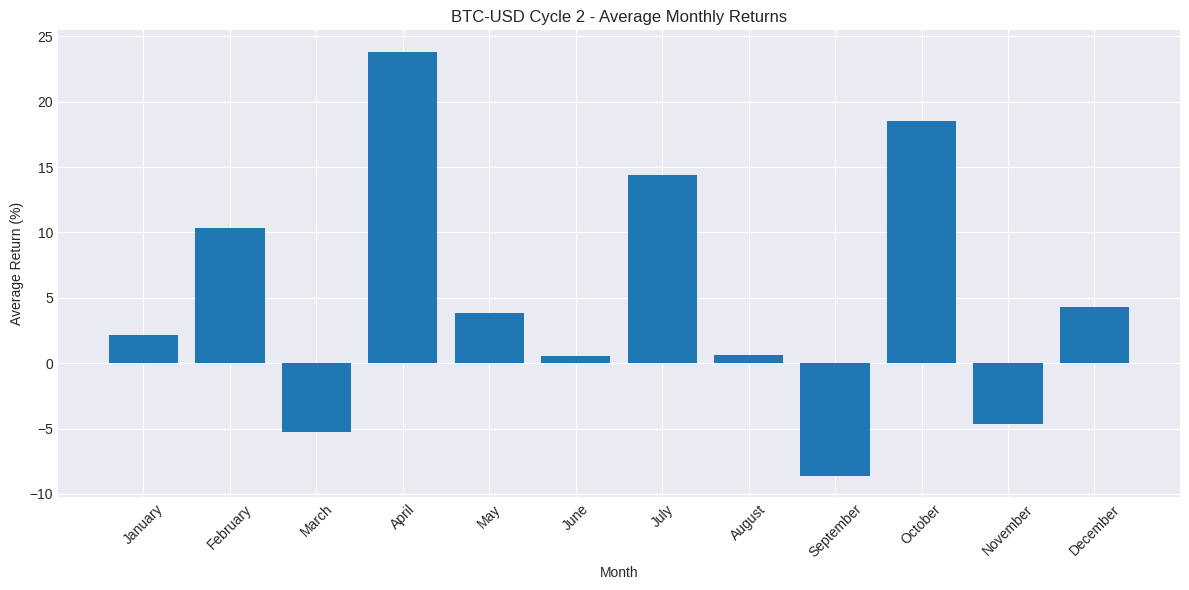

Data for ETH-USD fetched successfully.


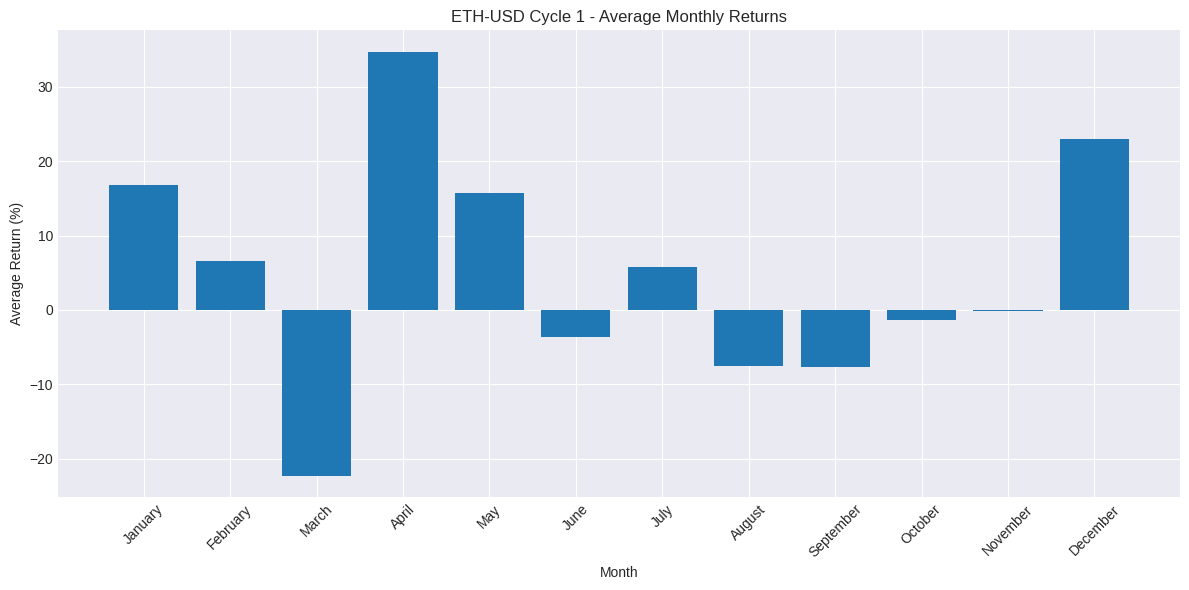

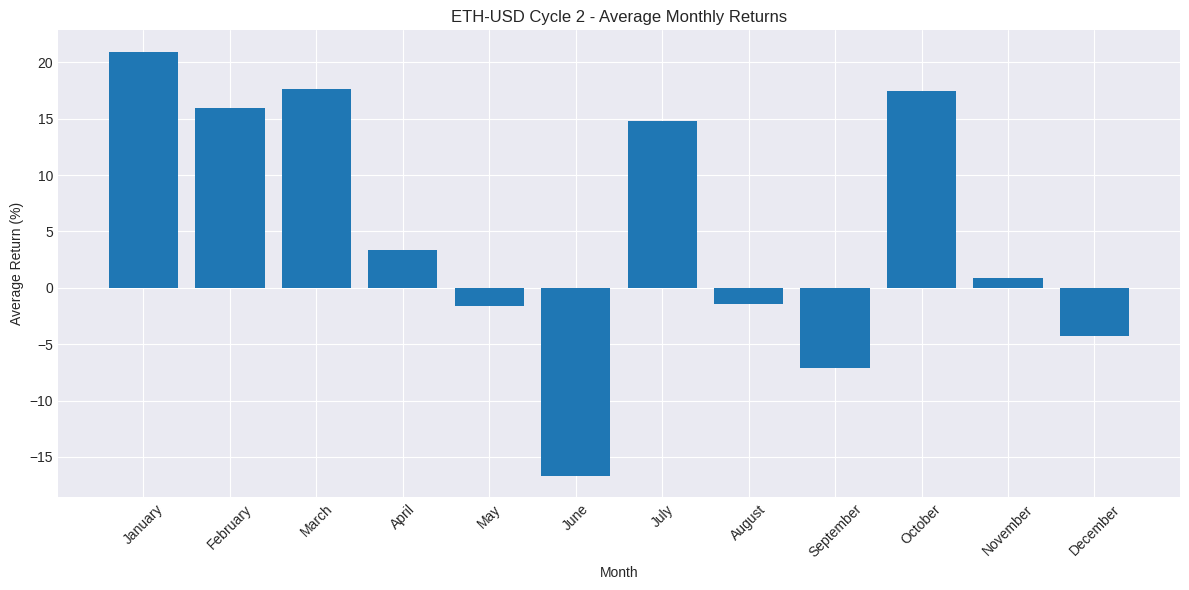

TypeError: __init__() missing 2 required positional arguments: 'end_date' and 'triple_witching_weeks'

In [16]:
if __name__ == "__main__":
    # Define tickers
    tickers = ['BTC-USD', 'ETH-USD']
    
    # Fetch data
    data = yf.download(tickers, start=start_date, end=end_date)
    print("Data fetched successfully.")
    
    # Initialize and run Technical Seasonality Analyzer
    tech_analyzer = TechnicalSeasonalityAnalyzer(data, tickers)
    tech_analyzer.calculate_technical_indicators()
    overbought_oversold_results = tech_analyzer.analyze_overbought_oversold()
    
    # Modify the plot_overbought_oversold method to use isocalendar().week instead of .week
    def modified_plot_overbought_oversold(self, overbought_oversold_results):
        for ticker in self.tickers:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
            
            # Monthly plot
            monthly_data_ob = overbought_oversold_results[ticker]['monthly_overbought'].groupby(overbought_oversold_results[ticker]['monthly_overbought'].index.month).mean()
            monthly_data_os = overbought_oversold_results[ticker]['monthly_oversold'].groupby(overbought_oversold_results[ticker]['monthly_oversold'].index.month).mean()
            
            ax1.bar(monthly_data_ob.index, monthly_data_ob.values, alpha=0.5, color='red', label='Overbought')
            ax1.bar(monthly_data_os.index, monthly_data_os.values, alpha=0.5, color='green', label='Oversold')
            ax1.set_title(f'{ticker} - Monthly Overbought/Oversold Frequency')
            ax1.set_xlabel('Month')
            ax1.set_ylabel('Frequency')
            ax1.set_xticks(range(1, 13))
            ax1.legend()
            
            # Weekly plot
            weekly_data_ob = overbought_oversold_results[ticker]['weekly_overbought'].groupby(overbought_oversold_results[ticker]['weekly_overbought'].index.isocalendar().week).mean()
            weekly_data_ob = weekly_data_ob.reindex(range(1, 53))
            weekly_data_os = overbought_oversold_results[ticker]['weekly_oversold'].groupby(overbought_oversold_results[ticker]['weekly_oversold'].index.isocalendar().week).mean()
            weekly_data_os = weekly_data_os.reindex(range(1, 53))
            
            ax2.bar(weekly_data_ob.index, weekly_data_ob.values, alpha=0.5, color='red', label='Overbought')
            ax2.bar(weekly_data_os.index, weekly_data_os.values, alpha=0.5, color='green', label='Oversold')
            ax2.set_title(f'{ticker} - Weekly Overbought/Oversold Frequency')
            ax2.set_xlabel('Week')
            ax2.set_ylabel('Frequency')
            ax2.set_xticks(range(1, 53, 4))
            ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    # Use the modified method
    modified_plot_overbought_oversold(tech_analyzer, overbought_oversold_results)
    
    # Initialize and run Monthly Seasonality Analyzer with 4-Year Cycles
    for ticker in tickers:
        monthly_analyzer = MonthlySeasonalityAnalyzer(ticker=ticker, start='2010-01-01', end=end_date)
        monthly_analyzer.fetch_and_process_data()
        monthly_analyzer.calculate_metrics()
        monthly_analyzer.visualize_data()
    
    # Initialize and run Weekly Seasonality Visualizer
    visualizer = WeeklySeasonalityVisualizer(data, tickers)
    visualizer.visualize_weekly_seasonality()
    
    # Initialize and run Cumulative Return Analyzer
    for ticker in tickers:
        cumulative_analyzer = CumulativeReturnAnalyzer(ticker=ticker, start_date='2010-01-01')
        cumulative_returns = cumulative_analyzer.process()
